In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

directory = 'participant_data'

# Load board configuration from JSON
board_config = {
    "scoring_left": 85,
    "scoring_top": 176,
    "scoring_width": 1341,
    "scoring_height": 150
}

scoring_left = board_config['scoring_left']
scoring_top = board_config['scoring_top']
scoring_width = board_config['scoring_width']
scoring_height = board_config['scoring_height']


In [2]:
dfs = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        dfs.append(df)

# Merge all subject data while ensuring correct structure
df_all = pd.concat(dfs, ignore_index=True)



# Verify merged data
df_all["subject_id"].unique() 

array(['AN', 'EH', ' AE'], dtype=object)

In [3]:
df_all

,x,y,feedback_block,subject_id
0,510.049601,454.986935,1,AN
1,390.678694,442.993648,1,EH
2,585.787416,534.921285,1,AE
3,100.000000,200.000000,4,AE
4,200.000000,300.000000,5,AE
5,300.000000,450.000000,6,AE
6,250.000000,250.000000,10,AE
7,350.000000,450.000000,7,AE


In [4]:
feedback_blocks_series = df_all['feedback_block']

feedback_blocks = {
    'trajectory': [4, 5, 6],
    'endpos': [7, 8, 9],
    'rl': [10, 11, 12],
    "no feedback": [1, 2, 3]  # Normal feedback type
}

feedback_types = pd.unique(feedback_blocks_series)


feedback_mapping = {}
for feedback_type, block_numbers in feedback_blocks.items():
    for block in block_numbers:
        feedback_mapping[block] = feedback_type        

feedback_mapping

{4: 'trajectory',
 5: 'trajectory',
 6: 'trajectory',
 7: 'endpos',
 8: 'endpos',
 9: 'endpos',
 10: 'rl',
 11: 'rl',
 12: 'rl',
 1: 'no feedback',
 2: 'no feedback',
 3: 'no feedback'}

In [5]:
# Apply the feedback mapping to the DataFrame
df_all['feedback_type'] = df_all['feedback_block'].map(feedback_mapping)
df_all

,x,y,feedback_block,subject_id,feedback_type
0,510.049601,454.986935,1,AN,no feedback
1,390.678694,442.993648,1,EH,no feedback
2,585.787416,534.921285,1,AE,no feedback
3,100.000000,200.000000,4,AE,trajectory
4,200.000000,300.000000,5,AE,trajectory
5,300.000000,450.000000,6,AE,trajectory
6,250.000000,250.000000,10,AE,rl
7,350.000000,450.000000,7,AE,endpos


In [14]:
feedback_colors = {
    'trajectory': 'blue',
    'endpos': 'red',
    'rl': 'green',
    "no feedback": 'black'
}

block_mapping = {
    1: "Block 1 (unperturbed)",
    2: "Block 2 (perturbed)",
    3: "Block 3 (unperturbed)"
}

# Define colors (matching the reference image)
dark_green = np.array([0, 100, 0]) / 255.0
light_green = np.array([144, 238, 144]) / 255.0
dark_red = np.array([139, 0, 0]) / 255.0
light_red = np.array([255, 182, 193]) / 255.0


In [7]:
def generate_gradient_image(scoring_rect, start_color, end_color):
    """Generate a gradient effect over a rectangular region with full RGB interpolation."""
    width, height = scoring_rect["scoring_width"], scoring_rect["scoring_height"]

    # Normalize colors to the range [0,1]
    start_color = np.array(start_color) / 255.0
    end_color = np.array(end_color) / 255.0

    # Create linear interpolation for all three RGB channels
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    X, Y = np.meshgrid(x, y)

    # Interpolate between start_color and end_color for each channel
    gradient_image = np.zeros((height, width, 3))
    for i in range(3):  # Loop over RGB channels
        gradient_image[:, :, i] = np.outer(np.ones(height), np.linspace(start_color[i], end_color[i], width))

    return gradient_image


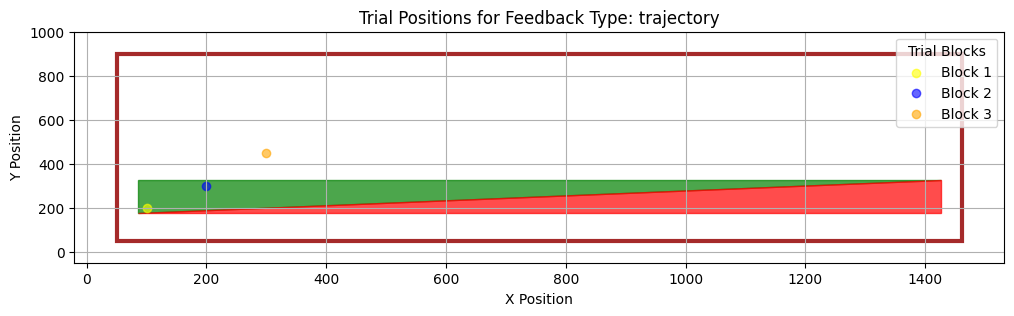

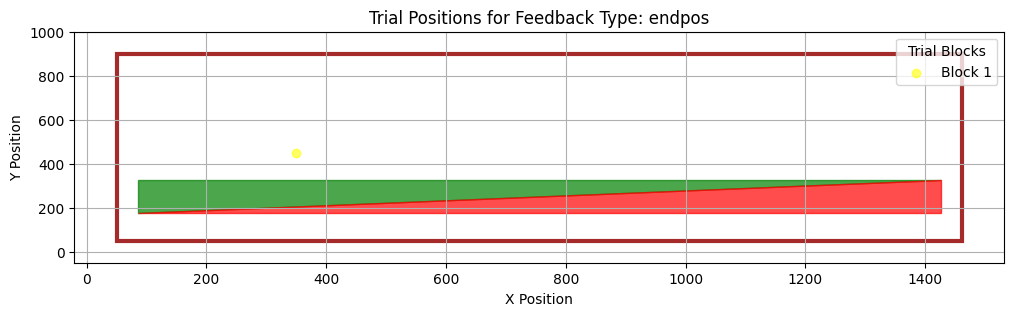

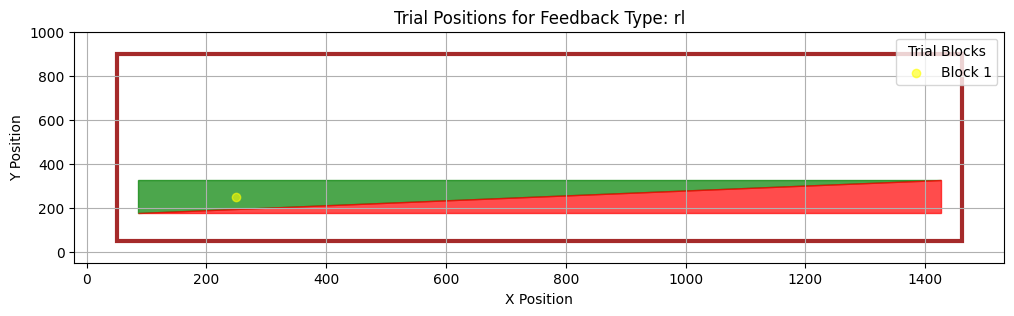

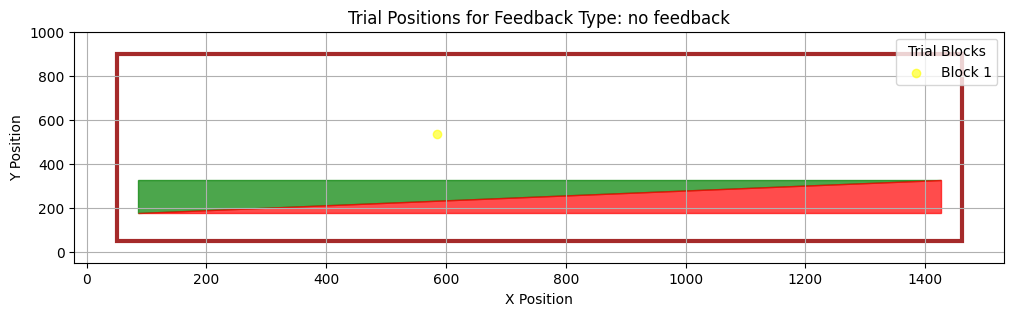

In [54]:
import matplotlib.patches as patches

subjects = df_all["subject_id"].unique()
# Generate separate plots for each feedback type
for fb_type in feedback_blocks.keys():
    plt.figure(figsize=(12, 3))

    # Filter trials for the current feedback type
    trials = df[df['feedback_type'] == fb_type].copy()

    # Map feedback blocks into block levels (1, 2, 3)
    trials['block_level'] = trials['feedback_block'].apply(lambda x: (x - 1) % 3 + 1)

    # Group trials by block level (1, 2, 3)
    grouped_feedback_block = trials.groupby('block_level')

    # ✅ **CORRECT GREEN & RED ZONES BASED ON JSON**
    red_polygon = patches.Polygon(
        [[1426, 326], [1426, 176], [85, 176]], color="red", alpha=0.7  # ✅ Red on RIGHT
    )
    green_polygon = patches.Polygon(
        [[85, 176], [85, 326], [1426, 326]], color="green", alpha=0.7  # ✅ Green on LEFT
    )

    plt.gca().add_patch(green_polygon)
    plt.gca().add_patch(red_polygon)

    # Plot each group within the feedback type
    block_colors = {1: 'yellow', 2: 'blue', 3: 'orange'}  # Fixed colors for blocks
    for block_level, group in grouped_feedback_block:
        if block_level in block_colors:
            plt.scatter(group['x'], group['y'], label=f"Block {block_level}", color=block_colors[block_level], alpha=0.6)

    # Use JSON's Table Rectangle to Draw the Exact Border**
    plt.gca().add_patch(plt.Rectangle(
        (50, 49), 1412, 850,  
        fill=False, edgecolor='brown', linewidth=3
    ))

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"Trial Positions for Feedback Type: {fb_type}")
    plt.legend(title="Trial Blocks", loc="upper right")

    # Extract table dimensions from JSON
    table_top = -50
    table_bottom = 1000
    
    # Dynamically adjust y-axis limits
    plt.ylim(table_bottom, table_top) 
    plt.gca().invert_yaxis()  

    plt.grid(True)

    # Show the plot for the current feedback type
    plt.show()


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_27867/3286742115.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  subject_colors = plt.cm.get_cmap("tab10")  # Use 'tab10' colormap for 10 distinct colors


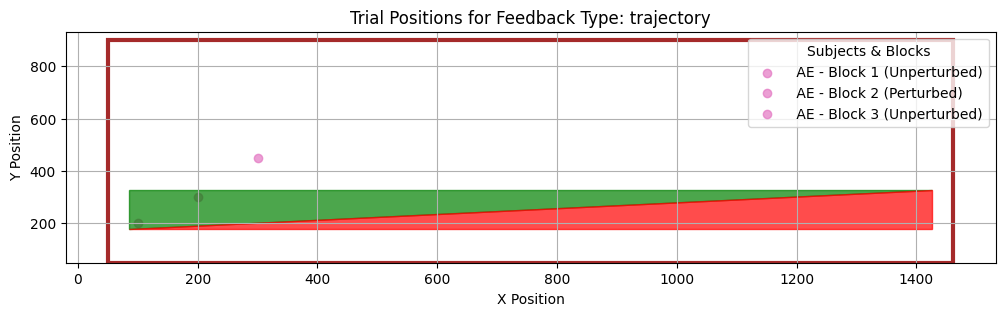

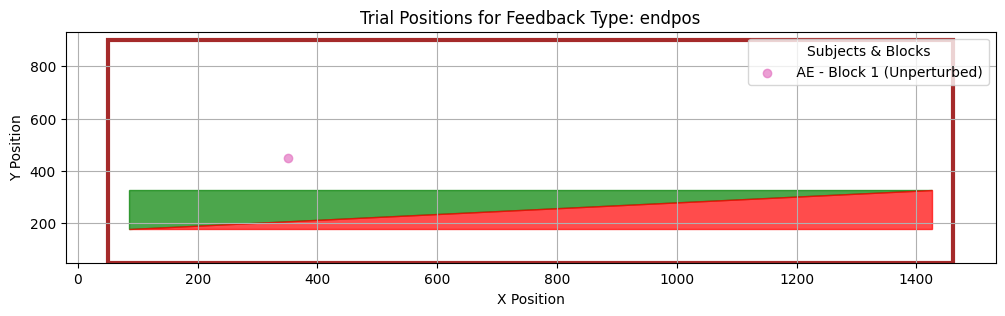

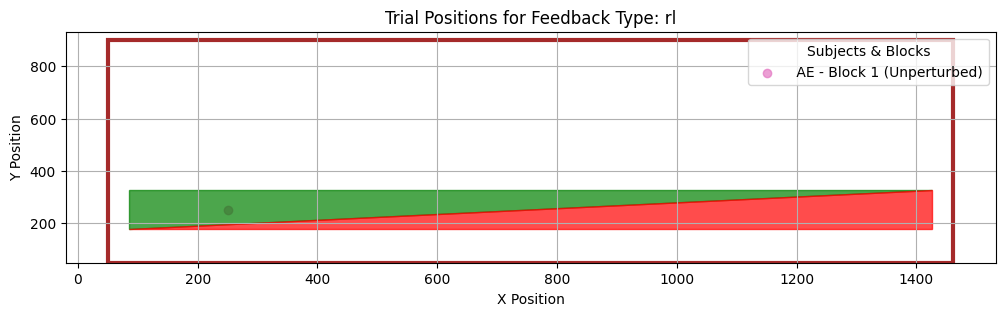

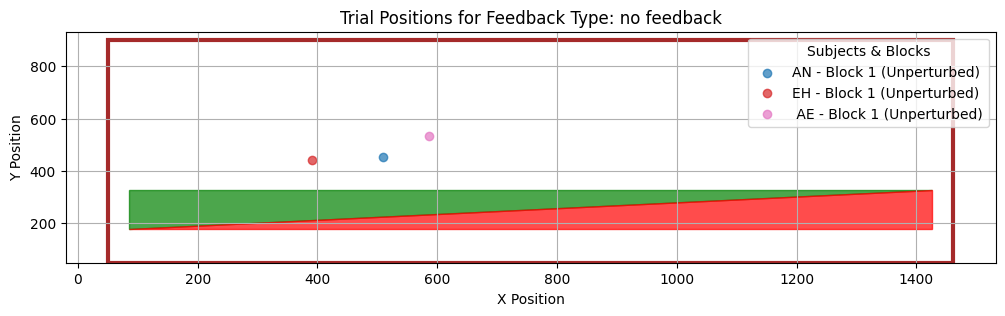

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Define a color map for subjects
subject_colors = plt.cm.get_cmap("tab10")  # Use 'tab10' colormap for 10 distinct colors

# Define block labels explicitly
block_labels = {1: "Block 1 (Unperturbed)", 
                2: "Block 2 (Perturbed)", 
                3: "Block 3 (Unperturbed)"}

# Get unique subjects
subjects = df_all["subject_id"].unique()
subject_color_map = {subject: subject_colors(i / len(subjects)) for i, subject in enumerate(subjects)}

# Generate separate plots for each feedback type
for fb_type in feedback_blocks.keys():
    plt.figure(figsize=(12, 3))

    # ✅ Loop over subjects & plot their data
    for subject in subjects:
        trials = df_all[(df_all["feedback_type"] == fb_type) & (df_all["subject_id"] == subject)].copy()

        # ✅ Map feedback blocks into block levels (1, 2, 3)
        trials["block_level"] = trials["feedback_block"].apply(lambda x: (x - 1) % 3 + 1)

        # ✅ Group trials by block level
        grouped_feedback_block = trials.groupby("block_level")

        # ✅ Use subject-specific colors
        for block_level, group in grouped_feedback_block:
            plt.scatter(group["x"], group["y"], 
                        label=f"{subject} - {block_labels[block_level]}",  # ✅ New legend labels
                        color=subject_color_map[subject], alpha=0.7)

    # ✅ **Correct Green & Red Zones from JSON**
    red_polygon = patches.Polygon([[1426, 326], [1426, 176], [85, 176]], color="red", alpha=0.7)
    green_polygon = patches.Polygon([[85, 176], [85, 326], [1426, 326]], color="green", alpha=0.7)
    plt.gca().add_patch(green_polygon)
    plt.gca().add_patch(red_polygon)

    # ✅ **Draw Table Boundary**
    plt.gca().add_patch(plt.Rectangle((50, 49), 1412, 850, fill=False, edgecolor="brown", linewidth=3))

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"Trial Positions for Feedback Type: {fb_type}")
    plt.legend(title="Subjects & Blocks", loc="upper right")

    # ✅ **Fix Y-axis scaling**
    plt.ylim(932, 49)  # Match table's coordinate system
    plt.gca().invert_yaxis()

    plt.grid(True)
    plt.show()


In [22]:
df

,x,y,feedback_block
0,585.787416,534.921285,1
1,100.000000,200.000000,4
2,200.000000,300.000000,5
3,300.000000,450.000000,6
4,250.000000,250.000000,10
5,350.000000,450.000000,7
